<a href="https://colab.research.google.com/github/NIKHIL0-0/hsbc_hackthon/blob/main/final_hsbc_hackathon_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
# Cell 1: Import Libraries
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')

🚀 FRAUD DETECTION MODEL TRAINING
Starting Fraud Detection Pipeline...
Loading training data from /content/Dataset.csv...
Training data loaded successfully. Shape: (535178, 10)
Dataset Shape: (535178, 10)

Data Types:
step             int64
customer        object
age             object
gender          object
zipcodeOri      object
merchant        object
zipMerchant     object
category        object
amount         float64
fraud            int64
dtype: object

Missing Values:
step           0
customer       0
age            0
gender         0
zipcodeOri     0
merchant       0
zipMerchant    0
category       0
amount         0
fraud          0
dtype: int64

Fraud Distribution:
fraud
0    528686
1      6492
Name: count, dtype: int64
Fraud Rate: 0.0121

Applying advanced feature engineering...
Preparing features for modeling...
Splitting data for training and validation...
Training set size: 428142
Validation set size: 107036

Training and comparing models...

Training Logistic Regression...

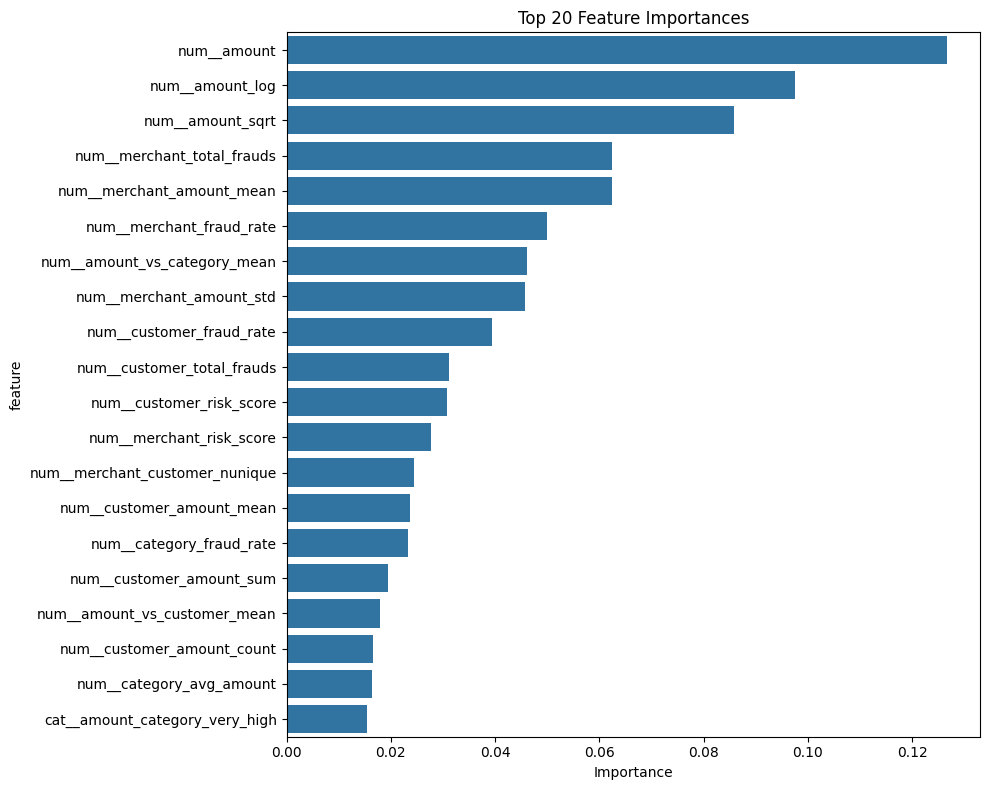


Saving trained model...
Model saved to fraud_model.pkl
Preprocessor info saved to preprocessor.pkl

TRAINING PIPELINE COMPLETED SUCCESSFULLY!

Model is ready for testing. When you receive the test dataset,

📊 TRAINING SUMMARY:
- Model trained and saved successfully
- Ready to make predictions on test data
- When test data is available, run:
  predict_on_test_data('/content/Dataset2.csv')

🔧 AVAILABLE FUNCTIONS:
- main_fraud_detection_pipeline(): Train the model
- predict_on_test_data(test_path): Make predictions on test data
- load_model_and_preprocessor(): Load saved model


In [21]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Load and examine the data
def load_and_examine_data(df):

    #Load and perform initial examination of the dataset

    print("Dataset Shape:", df.shape)
    print("\nData Types:")
    print(df.dtypes)
    print("\nMissing Values:")
    print(df.isnull().sum())
    print("\nFraud Distribution:")
    print(df['fraud'].value_counts())
    print(f"Fraud Rate: {df['fraud'].mean():.4f}")

    return df

def advanced_feature_engineering(df):

    #Create advanced features for fraud detection

    df_processed = df.copy()

    # 1. Customer-based aggregated features
    customer_stats = df_processed.groupby('customer').agg({
        'amount': ['count', 'sum', 'mean', 'std', 'min', 'max'],
        'fraud': ['sum', 'mean'],
        'category': 'nunique',
        'merchant': 'nunique'
    }).reset_index()

    # Flatten column names
    customer_stats.columns = ['customer'] + [f'customer_{col[0]}_{col[1]}' for col in customer_stats.columns[1:]]
    customer_stats.columns = [col.replace('customer_fraud_sum', 'customer_total_frauds')
                             for col in customer_stats.columns]
    customer_stats.columns = [col.replace('customer_fraud_mean', 'customer_fraud_rate')
                             for col in customer_stats.columns]

    # 2. Merchant-based aggregated features
    merchant_stats = df_processed.groupby('merchant').agg({
        'amount': ['count', 'sum', 'mean', 'std'],
        'fraud': ['sum', 'mean'],
        'customer': 'nunique'
    }).reset_index()

    # Flatten column names
    merchant_stats.columns = ['merchant'] + [f'merchant_{col[0]}_{col[1]}' for col in merchant_stats.columns[1:]]
    merchant_stats.columns = [col.replace('merchant_fraud_sum', 'merchant_total_frauds')
                             for col in merchant_stats.columns]
    merchant_stats.columns = [col.replace('merchant_fraud_mean', 'merchant_fraud_rate')
                             for col in merchant_stats.columns]

    # 3. Category-based features
    category_stats = df_processed.groupby('category').agg({
        'amount': ['mean', 'std'],
        'fraud': 'mean'
    }).reset_index()
    category_stats.columns = ['category', 'category_avg_amount', 'category_std_amount', 'category_fraud_rate']

    # 4. Time-based features (assuming step represents time)
    df_processed['step_hour'] = df_processed['step'] % 24
    df_processed['step_day'] = (df_processed['step'] // 24) % 7
    df_processed['step_week'] = df_processed['step'] // (24 * 7)

    # 5. Amount-based features
    df_processed['amount_log'] = np.log1p(df_processed['amount'])
    df_processed['amount_sqrt'] = np.sqrt(df_processed['amount'])

    # Amount categories
    df_processed['amount_category'] = pd.cut(df_processed['amount'],
                                           bins=[0, 10, 50, 100, 500, float('inf')],
                                           labels=['very_low', 'low', 'medium', 'high', 'very_high'])

    # 6. Demographic features
    # Age preprocessing (convert to numeric)
    df_processed['age_numeric'] = df_processed['age'].astype(str).str.extract('(\d+)').astype(float)

    # Age groups
    df_processed['age_group'] = pd.cut(df_processed['age_numeric'],
                                     bins=[0, 25, 35, 50, 65, 100],
                                     labels=['young', 'young_adult', 'middle_aged', 'senior', 'elderly'])

    # 7. Geographic features
    df_processed['same_zipcode'] = (df_processed['zipcodeOri'] == df_processed['zipMerchant']).astype(int)

    # 8. Interaction features
    df_processed['customer_merchant_interaction'] = df_processed['customer'] + '_' + df_processed['merchant']
    df_processed['gender_category_interaction'] = df_processed['gender'] + '_' + df_processed['category']

    # Merge aggregated features
    df_processed = df_processed.merge(customer_stats, on='customer', how='left')
    df_processed = df_processed.merge(merchant_stats, on='merchant', how='left')
    df_processed = df_processed.merge(category_stats, on='category', how='left')

    # 9. Deviation features (how much this transaction deviates from customer's normal behavior)
    df_processed['amount_vs_customer_mean'] = df_processed['amount'] / (df_processed['customer_amount_mean'] + 1e-6)
    df_processed['amount_vs_category_mean'] = df_processed['amount'] / (df_processed['category_avg_amount'] + 1e-6)

    # 10. Risk scores
    df_processed['merchant_risk_score'] = df_processed['merchant_fraud_rate'] * df_processed['merchant_amount_count']
    df_processed['customer_risk_score'] = df_processed['customer_fraud_rate'] * df_processed['customer_amount_count']

    return df_processed

def prepare_features(df):
    """
    Prepare features for modeling
    """
    # Define feature columns
    numeric_features = [
        'step', 'amount', 'amount_log', 'amount_sqrt', 'age_numeric', 'same_zipcode',
        'step_hour', 'step_day', 'step_week',
        'customer_amount_count', 'customer_amount_sum', 'customer_amount_mean',
        'customer_amount_std', 'customer_amount_min', 'customer_amount_max',
        'customer_total_frauds', 'customer_fraud_rate', 'customer_category_nunique',
        'customer_merchant_nunique', 'merchant_amount_count', 'merchant_amount_sum',
        'merchant_amount_mean', 'merchant_amount_std', 'merchant_total_frauds',
        'merchant_fraud_rate', 'merchant_customer_nunique', 'category_avg_amount',
        'category_std_amount', 'category_fraud_rate', 'amount_vs_customer_mean',
        'amount_vs_category_mean', 'merchant_risk_score', 'customer_risk_score'
    ]

    categorical_features = [
        'gender', 'category', 'amount_category', 'age_group'
    ]

    # Handle missing values in numeric features
    for col in numeric_features:
        if col in df.columns:
            df[col].fillna(df[col].median(), inplace=True)

    # Create feature matrix
    X = df[numeric_features + categorical_features].copy()
    y = df['fraud'].values

    return X, y, numeric_features, categorical_features

def create_preprocessing_pipeline(numeric_features, categorical_features):
    """
    Create preprocessing pipeline
    """
    # Numeric preprocessing
    numeric_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    # Categorical preprocessing
    categorical_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
    ])

    # Combine preprocessing
    preprocessor = ColumnTransformer([
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

    return preprocessor

def train_models(X_train, X_test, y_train, y_test, preprocessor):
    """
    Train multiple models and compare performance
    """
    models = {
        'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
        'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
        'Gradient Boosting': GradientBoostingClassifier(random_state=42, n_estimators=25)
    }

    results = {}
    trained_pipelines = {}

    for name, model in models.items():
        print(f"\nTraining {name}...")

        # Create pipeline
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', model)
        ])

        # Train model
        pipeline.fit(X_train, y_train)

        # Predictions
        y_train_pred = pipeline.predict(X_train)
        y_test_pred = pipeline.predict(X_test)
        y_test_prob = pipeline.predict_proba(X_test)[:, 1]

        # Metrics
        train_auc = roc_auc_score(y_train, pipeline.predict_proba(X_train)[:, 1])
        test_auc = roc_auc_score(y_test, y_test_prob)

        results[name] = {
            'train_auc': train_auc,
            'test_auc': test_auc,
            'predictions': y_test_pred,
            'probabilities': y_test_prob
        }

        trained_pipelines[name] = pipeline

        print(f"Train AUC: {train_auc:.4f}")
        print(f"Test AUC: {test_auc:.4f}")
        print("\nClassification Report:")
        print(classification_report(y_test, y_test_pred))

    return results, trained_pipelines

def optimize_best_model(X_train, y_train, preprocessor):
    """
    Optimize the best performing model using GridSearch
    """
    print("\nOptimizing Random Forest model...")
    #'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
    # Create pipeline
    rf_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(random_state=42))
    ])

    # Parameter grid
    param_grid = {
      'classifier__n_estimators': [50, 100]
    }

    # Grid search
    grid_search = GridSearchCV(
        rf_pipeline, param_grid, cv=3, scoring='roc_auc',
        n_jobs=-1, verbose=1
    )

    grid_search.fit(X_train, y_train)

    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

    return grid_search.best_estimator_

def evaluate_model(model, X_test, y_test, model_name="Model"):
    """
    Comprehensive model evaluation
    """
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    print(f"\n{model_name} Final Evaluation:")
    print("="*50)

    # AUC Score
    auc = roc_auc_score(y_test, y_prob)
    print(f"AUC Score: {auc:.4f}")

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_test, y_pred)
    print(cm)

    return auc, y_pred, y_prob

def plot_feature_importance(model, feature_names, top_n=20):
    """
    Plot feature importance
    """
    if hasattr(model.named_steps['classifier'], 'feature_importances_'):
        importance = model.named_steps['classifier'].feature_importances_

        # Get feature names after preprocessing
        if hasattr(model.named_steps['preprocessor'], 'get_feature_names_out'):
            feature_names = model.named_steps['preprocessor'].get_feature_names_out()

        # Create importance dataframe
        importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': importance
        }).sort_values('importance', ascending=False).head(top_n)

        # Plot
        plt.figure(figsize=(10, 8))
        sns.barplot(data=importance_df, x='importance', y='feature')
        plt.title(f'Top {top_n} Feature Importances')
        plt.xlabel('Importance')
        plt.tight_layout()
        plt.show()

        return importance_df

def save_model_and_preprocessor(model, preprocessor, feature_names, model_path="fraud_model.pkl", preprocessor_path="preprocessor.pkl"):
    """
    Save trained model and preprocessor for later use
    """
    import pickle

    # Save model
    with open(model_path, 'wb') as f:
        pickle.dump(model, f)

    # Save preprocessor info
    model_info = {
        'preprocessor': preprocessor,
        'feature_names': feature_names,
        'numeric_features': [col for col in feature_names if col not in ['gender', 'category', 'amount_category', 'age_group']],
        'categorical_features': ['gender', 'category', 'amount_category', 'age_group']
    }

    with open(preprocessor_path, 'wb') as f:
        pickle.dump(model_info, f)

    print(f"Model saved to {model_path}")
    print(f"Preprocessor info saved to {preprocessor_path}")

def load_model_and_preprocessor(model_path="fraud_model.pkl", preprocessor_path="preprocessor.pkl"):
    """
    Load trained model and preprocessor
    """
    import pickle

    with open(model_path, 'rb') as f:
        model = pickle.load(f)

    with open(preprocessor_path, 'rb') as f:
        model_info = pickle.load(f)

    return model, model_info

def predict_on_test_data(test_data_path="/content/Dataset2.csv", model_path="fraud_model.pkl", preprocessor_path="preprocessor.pkl"):
    """
    Load test data and make predictions using trained model
    """
    import pickle

    print(f"Loading test data from {test_data_path}...")

    # Load test data
    df_test = pd.read_csv(test_data_path)
    print(f"Test data shape: {df_test.shape}")

    # Load trained model and preprocessor info
    model, model_info = load_model_and_preprocessor(model_path, preprocessor_path)

    # Apply same feature engineering as training
    print("Applying feature engineering to test data...")
    df_test_processed = advanced_feature_engineering(df_test)

    # Prepare features (same as training)
    X_test, _, _, _ = prepare_features(df_test_processed)

    # Make predictions
    print("Making predictions...")
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    # Create results dataframe
    results_df = df_test.copy()
    results_df['predicted_fraud'] = y_pred
    results_df['fraud_probability'] = y_prob
    results_df['risk_level'] = pd.cut(y_prob,
                                    bins=[0, 0.3, 0.7, 1.0],
                                    labels=['Low', 'Medium', 'High'])

    # Save predictions
    results_df.to_csv('test_predictions.csv', index=False)
    print("Predictions saved to 'test_predictions.csv'")

    # Summary statistics
    print(f"\nPrediction Summary:")
    print(f"Total transactions: {len(results_df)}")
    print(f"Predicted frauds: {y_pred.sum()}")
    print(f"Fraud rate: {y_pred.mean():.4f}")
    print(f"Risk level distribution:")
    print(results_df['risk_level'].value_counts())

    return results_df

def main_fraud_detection_pipeline():
    """
    Main pipeline for fraud detection using specified file paths
    """
    print("Starting Fraud Detection Pipeline...")
    print("="*50)

    try:
        # 1. Load training data
        print("Loading training data from /content/Dataset.csv...")
        df = pd.read_csv('/content/Dataset.csv')
        print(f"Training data loaded successfully. Shape: {df.shape}")

        # 2. Examine data
        df = load_and_examine_data(df)

        # 3. Feature engineering
        print("\nApplying advanced feature engineering...")
        df_processed = advanced_feature_engineering(df)

        # 4. Prepare features
        print("Preparing features for modeling...")
        X, y, numeric_features, categorical_features = prepare_features(df_processed)

        # 5. Split data for validation
        print("Splitting data for training and validation...")
        X_train, X_val, y_train, y_val = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )

        print(f"Training set size: {X_train.shape[0]}")
        print(f"Validation set size: {X_val.shape[0]}")

        # 6. Create preprocessing pipeline
        preprocessor = create_preprocessing_pipeline(numeric_features, categorical_features)

        # 7. Train and compare models
        print("\nTraining and comparing models...")
        results, trained_pipelines = train_models(X_train, X_val, y_train, y_val, preprocessor)

        # 8. Optimize best model
        print("\nOptimizing best performing model...")
        best_model = optimize_best_model(X_train, y_train, preprocessor)

        # 9. Final evaluation on validation set
        print("\nFinal model evaluation...")
        auc, y_pred, y_prob = evaluate_model(best_model, X_val, y_val, "Optimized Random Forest")

        # 10. Feature importance analysis
        print("\nAnalyzing feature importance...")
        importance_df = plot_feature_importance(best_model, X.columns)

        # 11. Save model for later use on test data
        print("\nSaving trained model...")
        save_model_and_preprocessor(best_model, preprocessor, X.columns.tolist())

        print("\n" + "="*50)
        print("TRAINING PIPELINE COMPLETED SUCCESSFULLY!")
        print("="*50)
        #print("\nModel is ready for testing. When you receive the test dataset,")
        #print("run: predict_on_test_data('/content/Dataset2.csv')")

        return best_model, preprocessor, importance_df

    except FileNotFoundError:
        print("Error: Could not find /content/Dataset.csv")
        print("Please ensure the file exists in the specified location.")
        return None, None, None
    except Exception as e:
        print(f"An error occurred: {str(e)}")
        return None, None, None

# Example usage function
'''
def run_example_with_sample_data():

    #Run example with sample data structure similar to your dataset

    # Create sample data for demonstration
    np.random.seed(42)
    n_samples = 1000

    sample_data = {
        'step': np.random.randint(1, 200, n_samples),
        'customer': [f'C{i}' for i in np.random.randint(1000000, 9999999, n_samples)],
        'age': np.random.choice(['1', '2', '3', '4', '5'], n_samples),
        'gender': np.random.choice(['M', 'F'], n_samples),
        'zipcodeOri': np.random.choice(['28007', '28008', '28009'], n_samples),
        'merchant': [f'M{i}' for i in np.random.randint(100000, 999999, n_samples)],
        'zipMerchant': np.random.choice(['28007', '28008', '28009'], n_samples),
        'category': np.random.choice(['es_transportation', 'es_health', 'es_food', 'es_retail'], n_samples),
        'amount': np.random.lognormal(3, 1, n_samples),
        'fraud': np.random.choice([0, 1], n_samples, p=[0.95, 0.05])
    }

    df = pd.DataFrame(sample_data)

    print("Running example with sample data...")

    # Run the pipeline
    df = load_and_examine_data(df)
    df_processed = advanced_feature_engineering(df)
    X, y, numeric_features, categorical_features = prepare_features(df_processed)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    preprocessor = create_preprocessing_pipeline(numeric_features, categorical_features)
    results, trained_pipelines = train_models(X_train, X_test, y_train, y_test, preprocessor)

    print("\nExample completed! Use this structure with your actual dataset.")
'''
if __name__ == "__main__":
    # Run the main training pipeline
    print("FRAUD DETECTION MODEL TRAINING")
    print("="*60)

    # Train the model using Dataset.csv
    model, preprocessor, importance_df = main_fraud_detection_pipeline()

    if model is not None:
        print("\n TRAINING SUMMARY:")
        print("- Model trained and saved successfully")
        print("- Ready to make predictions on test data")
        print("- When test data is available, run:")
        print("  predict_on_test_data('/content/Dataset2.csv')")

        print("\n AVAILABLE FUNCTIONS:")
        print("- main_fraud_detection_pipeline(): Train the model")
        print("- predict_on_test_data(test_path): Make predictions on test data")
        print("- load_model_and_preprocessor(): Load saved model")



In [ ]:
results = predict_on_test_data('/content/Dataset2.csv') #final validation set
print("'test_predictions.csv' ready with results")

In [ ]:
test=pd.read_csv('/content/Dataset3.csv')#final validation set answers
pred=results['predicted_fraud']
print(roc_auc_score(test['fraud'], pred))
print(classification_report(test,pred))

